In [1]:
# question 1 
!mlflow --version

mlflow, version 2.13.0


In [4]:
# question 2
!ls Q2/output | wc -l

4


2024/05/23 08:23:34 INFO mlflow.tracking.fluent: Experiment with name 'NYC Taxi experiement2' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops/week2/mlruns/2', creation_time=1716452614430, experiment_id='2', last_update_time=1716452614430, lifecycle_stage='active', name='NYC Taxi experiement2', tags={}>

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [9]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829577

/tmp/ipykernel_4111/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_4111/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


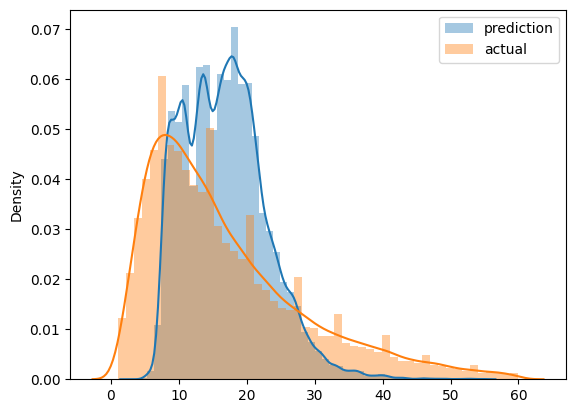

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [14]:
len(df_train), len(df_val)

(73908, 61921)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [16]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715209663881

In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [22]:
with mlflow.start_run():
    mlflow.set_tag("dev", "Remi")
    mlflow.log_param("train data", "'./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid data", "'./data/green_tripdata_2021-02.parquet")
alpha=0.01
lr = Lasso(alpha)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric("rmse",rmse)

mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [26]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [29]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:52:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.27234                           
[1]	validation-rmse:6.76945                           
[2]	validation-rmse:6.67952                           
[3]	validation-rmse:6.65135                           
[4]	validation-rmse:6.63515                           
[5]	validation-rmse:6.63033                           
[6]	validation-rmse:6.62480                           
[7]	validation-rmse:6.61762                           
[8]	validation-rmse:6.61458                           
[9]	validation-rmse:6.61250                           
[10]	validation-rmse:6.61102                          
[11]	validation-rmse:6.60926                          
[12]	validation-rmse:6.60610                          
[13]	validation-rmse:6.60257                          
[14]	validation-rmse:6.59900                          
[15]	validation-rmse:6.59678                          
[16]	validation-rmse:6.59481                          
[17]	validation-rmse:6.59357                          
[18]	valid

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:52:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.75440                                                    
[1]	validation-rmse:6.67012                                                    
[2]	validation-rmse:6.65232                                                    
[3]	validation-rmse:6.64450                                                    
[4]	validation-rmse:6.63548                                                    
[5]	validation-rmse:6.62436                                                    
[6]	validation-rmse:6.61311                                                    
[7]	validation-rmse:6.60651                                                    
[8]	validation-rmse:6.59989                                                    
[9]	validation-rmse:6.59490                                                    
[10]	validation-rmse:6.58642                                                   
[11]	validation-rmse:6.58069                                                   
[12]	validation-rmse:6.57633            

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:53:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.01183                                                   
[1]	validation-rmse:8.61281                                                    
[2]	validation-rmse:7.75475                                                    
[3]	validation-rmse:7.24241                                                    
[4]	validation-rmse:6.94111                                                    
[5]	validation-rmse:6.76210                                                    
[6]	validation-rmse:6.64802                                                    
[7]	validation-rmse:6.58098                                                    
[8]	validation-rmse:6.53091                                                    
[9]	validation-rmse:6.50040                                                    
[10]	validation-rmse:6.47751                                                   
[11]	validation-rmse:6.46272                                                   
[12]	validation-rmse:6.45143            

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:55:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.87701                                                   
[1]	validation-rmse:8.49052                                                   
[2]	validation-rmse:7.69973                                                   
[3]	validation-rmse:7.26096                                                   
[4]	validation-rmse:7.01181                                                   
[5]	validation-rmse:6.86728                                                   
[6]	validation-rmse:6.78609                                                   
[7]	validation-rmse:6.73846                                                   
[8]	validation-rmse:6.71003                                                   
[9]	validation-rmse:6.68947                                                   
[10]	validation-rmse:6.67688                                                  
[11]	validation-rmse:6.66690                                                  
[12]	validation-rmse:6.65955                        

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:57:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20025                                                    
[1]	validation-rmse:10.35560                                                    
[2]	validation-rmse:9.65664                                                     
[3]	validation-rmse:9.08106                                                     
[4]	validation-rmse:8.61152                                                     
[5]	validation-rmse:8.22972                                                     
[6]	validation-rmse:7.92079                                                     
[7]	validation-rmse:7.67250                                                     
[8]	validation-rmse:7.47275                                                     
[9]	validation-rmse:7.31336                                                     
[10]	validation-rmse:7.18636                                                    
[11]	validation-rmse:7.08109                                                    
[12]	validation-rmse:6.99679

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:59:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.45354                                                      
[1]	validation-rmse:7.25079                                                      
[2]	validation-rmse:6.88248                                                      
[3]	validation-rmse:6.76426                                                      
[4]	validation-rmse:6.71765                                                      
[5]	validation-rmse:6.69997                                                      
[6]	validation-rmse:6.69388                                                      
[7]	validation-rmse:6.69181                                                      
[8]	validation-rmse:6.68110                                                      
[9]	validation-rmse:6.67643                                                      
[10]	validation-rmse:6.67398                                                     
[11]	validation-rmse:6.66778                                                     
[12]	validation-

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:01:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.01138                                                      
[1]	validation-rmse:10.05103                                                      
[2]	validation-rmse:9.29003                                                       
[3]	validation-rmse:8.69267                                                       
[4]	validation-rmse:8.22919                                                       
[5]	validation-rmse:7.87186                                                       
[6]	validation-rmse:7.59810                                                       
[7]	validation-rmse:7.38811                                                       
[8]	validation-rmse:7.22903                                                       
[9]	validation-rmse:7.10741                                                       
[10]	validation-rmse:7.01326                                                      
[11]	validation-rmse:6.94098                                                      
[12]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:02:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71952                                                     
[1]	validation-rmse:11.26471                                                     
[2]	validation-rmse:10.84620                                                     
[3]	validation-rmse:10.46156                                                     
[4]	validation-rmse:10.10859                                                     
[5]	validation-rmse:9.78513                                                      
[6]	validation-rmse:9.48932                                                      
[7]	validation-rmse:9.21920                                                      
[8]	validation-rmse:8.97261                                                      
[9]	validation-rmse:8.74791                                                      
[10]	validation-rmse:8.54339                                                     
[11]	validation-rmse:8.35755                                                     
[12]	validation-

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:07:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54086                                                      
[1]	validation-rmse:10.94093                                                      
[2]	validation-rmse:10.40629                                                      
[3]	validation-rmse:9.93192                                                       
[4]	validation-rmse:9.51178                                                       
[5]	validation-rmse:9.13910                                                       
[6]	validation-rmse:8.81280                                                       
[7]	validation-rmse:8.52536                                                       
[8]	validation-rmse:8.27252                                                       
[9]	validation-rmse:8.05171                                                       
[10]	validation-rmse:7.85892                                                      
[11]	validation-rmse:7.69147                                                      
[12]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:10:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.75161                                                      
[1]	validation-rmse:11.32439                                                      
[2]	validation-rmse:10.92983                                                      
[3]	validation-rmse:10.56563                                                      
[4]	validation-rmse:10.22957                                                      
[5]	validation-rmse:9.91996                                                       
[6]	validation-rmse:9.63577                                                       
[7]	validation-rmse:9.37406                                                       
[8]	validation-rmse:9.13435                                                       
[9]	validation-rmse:8.91450                                                       
[10]	validation-rmse:8.71316                                                      
[11]	validation-rmse:8.52961                                                      
[12]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:12:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.73209                                                       
[1]	validation-rmse:9.61462                                                        
[2]	validation-rmse:8.78314                                                        
[3]	validation-rmse:8.17668                                                        
[4]	validation-rmse:7.73657                                                        
[5]	validation-rmse:7.41740                                                        
[6]	validation-rmse:7.18603                                                        
[7]	validation-rmse:7.02119                                                        
[8]	validation-rmse:6.90021                                                        
[9]	validation-rmse:6.81405                                                        
[10]	validation-rmse:6.74967                                                       
[11]	validation-rmse:6.70109                                                

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:14:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.02673                                                         
[1]	validation-rmse:7.04037                                                         
[2]	validation-rmse:6.80791                                                         
[3]	validation-rmse:6.73012                                                         
[4]	validation-rmse:6.69994                                                         
[5]	validation-rmse:6.68155                                                         
[6]	validation-rmse:6.67217                                                         
[7]	validation-rmse:6.66822                                                         
[8]	validation-rmse:6.66467                                                         
[9]	validation-rmse:6.66027                                                         
[10]	validation-rmse:6.65836                                                        
[11]	validation-rmse:6.65686                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:15:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.78140                                                        
[1]	validation-rmse:9.69465                                                         
[2]	validation-rmse:8.87722                                                         
[3]	validation-rmse:8.26788                                                         
[4]	validation-rmse:7.80853                                                         
[5]	validation-rmse:7.48766                                                         
[6]	validation-rmse:7.24456                                                         
[7]	validation-rmse:7.05927                                                         
[8]	validation-rmse:6.93951                                                         
[9]	validation-rmse:6.84862                                                         
[10]	validation-rmse:6.77354                                                        
[11]	validation-rmse:6.72388                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:18:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.17564                                                         
[1]	validation-rmse:6.77797                                                         
[2]	validation-rmse:6.70686                                                         
[3]	validation-rmse:6.68957                                                         
[4]	validation-rmse:6.67335                                                         
[5]	validation-rmse:6.66551                                                         
[6]	validation-rmse:6.65607                                                         
[7]	validation-rmse:6.65531                                                         
[8]	validation-rmse:6.65425                                                         
[9]	validation-rmse:6.65043                                                         
[10]	validation-rmse:6.64391                                                        
[11]	validation-rmse:6.64265                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:19:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.71461                                                         
[1]	validation-rmse:7.31260                                                         
[2]	validation-rmse:6.79627                                                         
[3]	validation-rmse:6.59340                                                         
[4]	validation-rmse:6.51331                                                         
[5]	validation-rmse:6.47276                                                         
[6]	validation-rmse:6.44893                                                         
[7]	validation-rmse:6.43385                                                         
[8]	validation-rmse:6.42626                                                         
[9]	validation-rmse:6.42070                                                         
[10]	validation-rmse:6.41469                                                        
[11]	validation-rmse:6.41002                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:20:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.31340                                                     
[1]	validation-rmse:10.54151                                                     
[2]	validation-rmse:9.88301                                                      
[3]	validation-rmse:9.32422                                                      
[4]	validation-rmse:8.85231                                                      
[5]	validation-rmse:8.45443                                                      
[6]	validation-rmse:8.12101                                                      
[7]	validation-rmse:7.84331                                                      
[8]	validation-rmse:7.61184                                                      
[9]	validation-rmse:7.41990                                                      
[10]	validation-rmse:7.26108                                                     
[11]	validation-rmse:7.13031                                                     
[12]	validation-

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:24:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.62464                                                        
[1]	validation-rmse:11.09254                                                        
[2]	validation-rmse:10.61254                                                        
[3]	validation-rmse:10.18041                                                        
[4]	validation-rmse:9.79221                                                         
[5]	validation-rmse:9.44364                                                         
[6]	validation-rmse:9.13187                                                         
[7]	validation-rmse:8.85394                                                         
[8]	validation-rmse:8.60598                                                         
[9]	validation-rmse:8.38557                                                         
[10]	validation-rmse:8.18958                                                        
[11]	validation-rmse:8.01606                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:26:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86054                                                         
[1]	validation-rmse:7.43638                                                         
[2]	validation-rmse:6.87523                                                         
[3]	validation-rmse:6.65106                                                         
[4]	validation-rmse:6.54861                                                         
[5]	validation-rmse:6.49789                                                         
[6]	validation-rmse:6.47056                                                         
[7]	validation-rmse:6.45460                                                         
[8]	validation-rmse:6.43961                                                         
[9]	validation-rmse:6.43231                                                         
[10]	validation-rmse:6.42560                                                        
[11]	validation-rmse:6.42207                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:28:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.35799                                                         
[1]	validation-rmse:6.81991                                                         
[2]	validation-rmse:6.74108                                                         
[3]	validation-rmse:6.72311                                                         
[4]	validation-rmse:6.71724                                                         
[5]	validation-rmse:6.70989                                                         
[6]	validation-rmse:6.70595                                                         
[7]	validation-rmse:6.70030                                                         
[8]	validation-rmse:6.69858                                                         
[9]	validation-rmse:6.69601                                                         
[10]	validation-rmse:6.69266                                                        
[11]	validation-rmse:6.68987                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:28:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.61520                                                     
[1]	validation-rmse:11.07497                                                     
[2]	validation-rmse:10.58813                                                     
[3]	validation-rmse:10.15053                                                     
[4]	validation-rmse:9.75761                                                      
[5]	validation-rmse:9.40576                                                      
[6]	validation-rmse:9.09119                                                      
[7]	validation-rmse:8.81156                                                      
[8]	validation-rmse:8.56218                                                      
[9]	validation-rmse:8.34055                                                      
[10]	validation-rmse:8.14419                                                     
[11]	validation-rmse:7.97083                                                     
[12]	validation-

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:10.44372                                                        
[1]	validation-rmse:9.22127                                                         
[2]	validation-rmse:8.39909                                                         
 40%|████      | 20/50 [42:01<1:22:52, 165.75s/trial, best loss: 6.3010721135330305]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:34:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.85706                                                         
[4]	validation-rmse:7.50532                                                         
[5]	validation-rmse:7.27581                                                         
[6]	validation-rmse:7.12527                                                         
[7]	validation-rmse:7.02736                                                         
[8]	validation-rmse:6.96107                                                         
[9]	validation-rmse:6.91848                                                         
[10]	validation-rmse:6.88772                                                        
[11]	validation-rmse:6.86496                                                        
[12]	validation-rmse:6.85055                                                        
[13]	validation-rmse:6.83920                                                        
[14]	validation-rmse:6.83221                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:35:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.32631                                                         
[1]	validation-rmse:7.86845                                                         
[2]	validation-rmse:7.17798                                                         
[3]	validation-rmse:6.85524                                                         
[4]	validation-rmse:6.69787                                                         
[5]	validation-rmse:6.61259                                                         
[6]	validation-rmse:6.56292                                                         
[7]	validation-rmse:6.53478                                                         
[8]	validation-rmse:6.51616                                                         
[9]	validation-rmse:6.50518                                                         
[10]	validation-rmse:6.49633                                                        
[11]	validation-rmse:6.49540                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:36:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.47130                                                       
[1]	validation-rmse:8.03199                                                       
[2]	validation-rmse:7.31241                                                       
[3]	validation-rmse:6.96056                                                       
[4]	validation-rmse:6.78926                                                       
[5]	validation-rmse:6.68878                                                       
[6]	validation-rmse:6.63572                                                       
[7]	validation-rmse:6.60408                                                       
[8]	validation-rmse:6.58329                                                       
[9]	validation-rmse:6.56987                                                       
[10]	validation-rmse:6.55879                                                      
[11]	validation-rmse:6.55222                                                      
[12]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:37:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.58375                                                      
[1]	validation-rmse:9.38895                                                       
[2]	validation-rmse:8.52498                                                       
[3]	validation-rmse:7.91894                                                       
[4]	validation-rmse:7.49133                                                       
[5]	validation-rmse:7.19343                                                       
[6]	validation-rmse:6.98440                                                       
[7]	validation-rmse:6.83890                                                       
[8]	validation-rmse:6.73615                                                       
[9]	validation-rmse:6.66431                                                       
[10]	validation-rmse:6.61217                                                      
[11]	validation-rmse:6.57284                                                      
[12]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:39:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.52924                                                       
[1]	validation-rmse:8.10251                                                       
[2]	validation-rmse:7.38003                                                       
[3]	validation-rmse:7.02620                                                       
[4]	validation-rmse:6.83856                                                       
[5]	validation-rmse:6.74141                                                       
[6]	validation-rmse:6.68146                                                       
[7]	validation-rmse:6.64732                                                       
[8]	validation-rmse:6.62581                                                       
[9]	validation-rmse:6.61502                                                       
[10]	validation-rmse:6.60739                                                      
[11]	validation-rmse:6.60068                                                      
[12]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:41:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.32530                                                     
[1]	validation-rmse:9.02916                                                      
[2]	validation-rmse:8.15795                                                      
[3]	validation-rmse:7.59017                                                      
[4]	validation-rmse:7.22314                                                      
[5]	validation-rmse:6.98026                                                      
[6]	validation-rmse:6.82243                                                      
[7]	validation-rmse:6.72026                                                      
[8]	validation-rmse:6.64908                                                      
[9]	validation-rmse:6.60044                                                      
[10]	validation-rmse:6.56417                                                     
[11]	validation-rmse:6.53826                                                     
[12]	validation-

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:42:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.06131                                                      
[1]	validation-rmse:10.12535                                                      
[2]	validation-rmse:9.37218                                                       
[3]	validation-rmse:8.77143                                                       
[4]	validation-rmse:8.29538                                                       
[5]	validation-rmse:7.91993                                                       
[6]	validation-rmse:7.62673                                                       
[7]	validation-rmse:7.39846                                                       
[8]	validation-rmse:7.22074                                                       
[9]	validation-rmse:7.08150                                                       
[10]	validation-rmse:6.97440                                                      
[11]	validation-rmse:6.89057                                                      
[12]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:45:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.38003                                                      
[1]	validation-rmse:10.65675                                                      
[2]	validation-rmse:10.03125                                                      
[3]	validation-rmse:9.49544                                                       
[4]	validation-rmse:9.03528                                                       
[5]	validation-rmse:8.64198                                                       
[6]	validation-rmse:8.30715                                                       
[7]	validation-rmse:8.02510                                                       
[8]	validation-rmse:7.78504                                                       
[9]	validation-rmse:7.58198                                                       
[10]	validation-rmse:7.41089                                                      
[11]	validation-rmse:7.26877                                                      
[12]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:48:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.84323                                                      
[1]	validation-rmse:9.78794                                                       
[2]	validation-rmse:8.98219                                                       
[3]	validation-rmse:8.37508                                                       
[4]	validation-rmse:7.91883                                                       
[5]	validation-rmse:7.58201                                                       
[6]	validation-rmse:7.33052                                                       
[7]	validation-rmse:7.14798                                                       
[8]	validation-rmse:7.00841                                                       
[9]	validation-rmse:6.90829                                                       
[10]	validation-rmse:6.83141                                                      
[11]	validation-rmse:6.77131                                                      
[12]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:51:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.41527                                                       
[1]	validation-rmse:7.94303                                                       
[2]	validation-rmse:7.22031                                                       
[3]	validation-rmse:6.86774                                                       
[4]	validation-rmse:6.69436                                                       
[5]	validation-rmse:6.60337                                                       
[6]	validation-rmse:6.55040                                                       
[7]	validation-rmse:6.51672                                                       
[8]	validation-rmse:6.49567                                                       
[9]	validation-rmse:6.48181                                                       
[10]	validation-rmse:6.47407                                                      
[11]	validation-rmse:6.46768                                                      
[12]

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:52:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.96420                                                         
[1]	validation-rmse:7.03877                                                         
[2]	validation-rmse:6.83556                                                         
[3]	validation-rmse:6.78285                                                         
[4]	validation-rmse:6.76426                                                         
[5]	validation-rmse:6.75198                                                         
[6]	validation-rmse:6.74834                                                         
[7]	validation-rmse:6.74433                                                         
[8]	validation-rmse:6.73723                                                         
[9]	validation-rmse:6.72381                                                         
[10]	validation-rmse:6.72082                                                        
[11]	validation-rmse:6.71515                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:53:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.18952                                                       
[1]	validation-rmse:8.86015                                                        
[2]	validation-rmse:8.02132                                                        
[3]	validation-rmse:7.49482                                                        
[4]	validation-rmse:7.16909                                                        
[5]	validation-rmse:6.95848                                                        
[6]	validation-rmse:6.83295                                                        
[7]	validation-rmse:6.75141                                                        
[8]	validation-rmse:6.69472                                                        
[9]	validation-rmse:6.65883                                                        
[10]	validation-rmse:6.63204                                                       
[11]	validation-rmse:6.61298                                                

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:55:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.94351                                                         
[1]	validation-rmse:8.56559                                                         
[2]	validation-rmse:7.76134                                                         
[3]	validation-rmse:7.29152                                                         
[4]	validation-rmse:7.03007                                                         
[5]	validation-rmse:6.87261                                                         
[6]	validation-rmse:6.78221                                                         
[7]	validation-rmse:6.72666                                                         
[8]	validation-rmse:6.69032                                                         
[9]	validation-rmse:6.66595                                                         
[10]	validation-rmse:6.65112                                                        
[11]	validation-rmse:6.63914                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:57:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.94280                                                         
[1]	validation-rmse:7.53191                                                         
[2]	validation-rmse:6.96710                                                         
[3]	validation-rmse:6.73356                                                         
[4]	validation-rmse:6.63250                                                         
[5]	validation-rmse:6.58446                                                         
[6]	validation-rmse:6.55536                                                         
[7]	validation-rmse:6.53953                                                         
[8]	validation-rmse:6.52646                                                         
[9]	validation-rmse:6.51950                                                         
[10]	validation-rmse:6.51447                                                        
[11]	validation-rmse:6.50932                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:58:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.19065                                                       
[1]	validation-rmse:10.33553                                                       
[2]	validation-rmse:9.62466                                                        
[3]	validation-rmse:9.03937                                                        
[4]	validation-rmse:8.55702                                                        
[5]	validation-rmse:8.16396                                                        
[6]	validation-rmse:7.84408                                                        
[7]	validation-rmse:7.58685                                                        
[8]	validation-rmse:7.37949                                                        
[9]	validation-rmse:7.21197                                                        
[10]	validation-rmse:7.07835                                                       
[11]	validation-rmse:6.96963                                                

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:01:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.60948                                                        
[1]	validation-rmse:9.43640                                                         
[2]	validation-rmse:8.59007                                                         
[3]	validation-rmse:7.99399                                                         
[4]	validation-rmse:7.57431                                                         
[5]	validation-rmse:7.28546                                                         
[6]	validation-rmse:7.08494                                                         
[7]	validation-rmse:6.94553                                                         
[8]	validation-rmse:6.84849                                                         
[9]	validation-rmse:6.77790                                                         
[10]	validation-rmse:6.72753                                                        
[11]	validation-rmse:6.69146                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:03:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.88153                                                         
[1]	validation-rmse:6.74148                                                         
[2]	validation-rmse:6.71593                                                         
[3]	validation-rmse:6.70452                                                         
[4]	validation-rmse:6.70489                                                         
[5]	validation-rmse:6.70200                                                         
[6]	validation-rmse:6.69702                                                         
[7]	validation-rmse:6.69291                                                         
[8]	validation-rmse:6.68859                                                         
[9]	validation-rmse:6.69325                                                         
[10]	validation-rmse:6.68825                                                        
[11]	validation-rmse:6.67935                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:03:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.85209                                                        
[1]	validation-rmse:8.46877                                                        
[2]	validation-rmse:7.69454                                                        
[3]	validation-rmse:7.26736                                                        
[4]	validation-rmse:7.03594                                                        
[5]	validation-rmse:6.90076                                                        
[6]	validation-rmse:6.82587                                                        
[7]	validation-rmse:6.78270                                                        
[8]	validation-rmse:6.75330                                                        
[9]	validation-rmse:6.73484                                                        
[10]	validation-rmse:6.72256                                                       
[11]	validation-rmse:6.71590                                                

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:04:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.15121                                                        
[1]	validation-rmse:6.99283                                                        
[2]	validation-rmse:6.66950                                                        
[3]	validation-rmse:6.56070                                                        
[4]	validation-rmse:6.51244                                                        
[5]	validation-rmse:6.49548                                                        
[6]	validation-rmse:6.49169                                                        
[7]	validation-rmse:6.48108                                                        
[8]	validation-rmse:6.47623                                                        
[9]	validation-rmse:6.46960                                                        
[10]	validation-rmse:6.46301                                                       
[11]	validation-rmse:6.45670                                                

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:05:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.88642                                                       
[1]	validation-rmse:9.84732                                                        
[2]	validation-rmse:9.04131                                                        
[3]	validation-rmse:8.42170                                                        
[4]	validation-rmse:7.95283                                                        
[5]	validation-rmse:7.60233                                                        
[6]	validation-rmse:7.33783                                                        
[7]	validation-rmse:7.14200                                                        
[8]	validation-rmse:6.99175                                                        
[9]	validation-rmse:6.87930                                                        
[10]	validation-rmse:6.79556                                                       
[11]	validation-rmse:6.73189                                                

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:07:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.42571                                                       
[1]	validation-rmse:10.73584                                                       
[2]	validation-rmse:10.13368                                                       
[3]	validation-rmse:9.61054                                                        
[4]	validation-rmse:9.15442                                                        
[5]	validation-rmse:8.76406                                                        
[6]	validation-rmse:8.42437                                                        
[7]	validation-rmse:8.13590                                                        
[8]	validation-rmse:7.88619                                                        
[9]	validation-rmse:7.67492                                                        
[10]	validation-rmse:7.49428                                                       
[11]	validation-rmse:7.34094                                                

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:11:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20539                                                        
[1]	validation-rmse:10.36716                                                        
[2]	validation-rmse:9.67253                                                         
[3]	validation-rmse:9.10042                                                         
[4]	validation-rmse:8.63562                                                         
[5]	validation-rmse:8.25417                                                         
[6]	validation-rmse:7.94777                                                         
[7]	validation-rmse:7.69884                                                         
[8]	validation-rmse:7.50068                                                         
[9]	validation-rmse:7.33790                                                         
[10]	validation-rmse:7.20986                                                        
[11]	validation-rmse:7.10573                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:14:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.62941                                                         
[1]	validation-rmse:7.37520                                                         
[2]	validation-rmse:6.96875                                                         
[3]	validation-rmse:6.82874                                                         
[4]	validation-rmse:6.76495                                                         
[5]	validation-rmse:6.73314                                                         
[6]	validation-rmse:6.71036                                                         
[7]	validation-rmse:6.70105                                                         
[8]	validation-rmse:6.69437                                                         
[9]	validation-rmse:6.69201                                                         
[10]	validation-rmse:6.68940                                                        
[11]	validation-rmse:6.68781                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:15:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.47818                                                         
[1]	validation-rmse:6.72178                                                         
[2]	validation-rmse:6.58996                                                         
[3]	validation-rmse:6.54614                                                         
[4]	validation-rmse:6.52332                                                         
[5]	validation-rmse:6.51732                                                         
[6]	validation-rmse:6.51138                                                         
[7]	validation-rmse:6.50323                                                         
[8]	validation-rmse:6.49677                                                         
[9]	validation-rmse:6.48106                                                         
[10]	validation-rmse:6.47634                                                        
[11]	validation-rmse:6.47150                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:16:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.76194                                                         
[1]	validation-rmse:6.73542                                                         
[2]	validation-rmse:6.72507                                                         
[3]	validation-rmse:6.71653                                                         
[4]	validation-rmse:6.70554                                                         
[5]	validation-rmse:6.70536                                                         
[6]	validation-rmse:6.70352                                                         
[7]	validation-rmse:6.69707                                                         
[8]	validation-rmse:6.69229                                                         
[9]	validation-rmse:6.68495                                                         
[10]	validation-rmse:6.68071                                                        
[11]	validation-rmse:6.67533                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:16:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.25057                                                        
[1]	validation-rmse:7.83395                                                        
[2]	validation-rmse:7.18612                                                        
[3]	validation-rmse:6.88152                                                        
[4]	validation-rmse:6.74407                                                        
[5]	validation-rmse:6.67216                                                        
[6]	validation-rmse:6.63234                                                        
[7]	validation-rmse:6.60874                                                        
[8]	validation-rmse:6.59090                                                        
[9]	validation-rmse:6.58196                                                        
[10]	validation-rmse:6.57580                                                       
[11]	validation-rmse:6.57072                                                

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:18:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.58061                                                       
[1]	validation-rmse:9.38287                                                        
[2]	validation-rmse:8.52017                                                        
[3]	validation-rmse:7.90707                                                        
[4]	validation-rmse:7.47936                                                        
[5]	validation-rmse:7.18389                                                        
[6]	validation-rmse:6.98175                                                        
[7]	validation-rmse:6.83799                                                        
[8]	validation-rmse:6.73414                                                        
[9]	validation-rmse:6.66378                                                        
[10]	validation-rmse:6.61263                                                       
[11]	validation-rmse:6.57178                                                

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:20:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.07127                                                       
[1]	validation-rmse:10.14333                                                       
[2]	validation-rmse:9.39557                                                        
[3]	validation-rmse:8.79855                                                        
[4]	validation-rmse:8.32544                                                        
[5]	validation-rmse:7.95114                                                        
[6]	validation-rmse:7.66005                                                        
[7]	validation-rmse:7.43295                                                        
[8]	validation-rmse:7.25571                                                        
[9]	validation-rmse:7.11732                                                        
[10]	validation-rmse:7.00847                                                       
[11]	validation-rmse:6.92487                                                

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:22:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.14308                                                        
[1]	validation-rmse:8.80234                                                         
[2]	validation-rmse:7.96156                                                         
[3]	validation-rmse:7.42084                                                         
[4]	validation-rmse:7.11093                                                         
[5]	validation-rmse:6.91286                                                         
[6]	validation-rmse:6.79083                                                         
[7]	validation-rmse:6.70473                                                         
[8]	validation-rmse:6.65441                                                         
[9]	validation-rmse:6.62018                                                         
[10]	validation-rmse:6.58584                                                        
[11]	validation-rmse:6.56732                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:24:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69787                                                        
[1]	validation-rmse:11.22466                                                        
[2]	validation-rmse:10.79051                                                        
[3]	validation-rmse:10.39286                                                        
[4]	validation-rmse:10.02962                                                        
[5]	validation-rmse:9.69906                                                         
[6]	validation-rmse:9.39752                                                         
[7]	validation-rmse:9.12201                                                         
[8]	validation-rmse:8.87362                                                         
[9]	validation-rmse:8.64740                                                         
[10]	validation-rmse:8.44226                                                        
[11]	validation-rmse:8.25718                                     

/workspaces/mlops/env_mlops/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [28]:
mlflow.end_run()